# CNN Training

Target of this code is to train a CNN network to extract the needle position of an analog needle device.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
########### Basic Parameters for Running: ################################
    
TFlite_Version  = "1501"   
TFlite_MainType = "ana-cont"
TFlite_Size     = "s0"
Training_Percentage = 0.05              # 0.0 = Use all Images for Training

##########################################################################

## 2024-03-30: Code adapted to TF 2.16####################################



import os
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import History 
import math
from PIL import Image 

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

### Load training data
* The data is expected in the "Input_dir"
* Picture size must be 32x32 with 3 color channels (RGB)
* The filename contains the informations needed for training in the first 3 digits::
* Typical filename: 
    * x.y-zzzz.jpg 
    * e.g. "4.6_Lfd-1406_zeiger3_2019-06-02T050011"

|Place holder | Meaning                     | Usage        |
|------------- |-----------------------------|--------------|
| **x.y**          | readout value               | **to be learned** |
| zzzz        | additional information              | not needed   |

* The images are stored in the x_data[]
* The expected output for each image in the corresponding y_data[]
    * The periodic nature is reflected in a **sin/cos coding**, which allows to restore the angle/counter value with an arctan later on.

* The last step is a shuffle (from sklearn.utils) as the filenames are on order due to the encoding of the expected analog readout in the filename 

In [2]:
Input_dir='data_resize_all'

files = glob.glob(Input_dir + '/*.*')
x_data = []
y_data = []

for aktfile in files:
    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    test_image = np.reshape(test_image, (32,32,3))
    base = os.path.basename(aktfile)
    target_number = (float(base[0:3])) / 10
    target_sin = math.sin(target_number * math.pi * 2)
    target_cos = math.cos(target_number * math.pi * 2)

    x_data.append(test_image)
    zw = np.array([target_sin, target_cos])
    y_data.append(zw)

x_data = np.array(x_data)
y_data = np.array(y_data)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)

if (Training_Percentage > 0):
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)
else:
    X_train = x_data
    y_train = y_data

(909, 32, 32, 3)
(909, 2)


### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 32, 3)
* Shape of the output layer: (2) - sin and cos

In [3]:
inputs = tf.keras.Input(shape=(32, 32, 3))
inputs2 = tf.keras.layers.BatchNormalization()(inputs)
inputs3 = tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation="relu")(inputs2)
inputs4 = tf.keras.layers.MaxPool2D(pool_size=(4,4))(inputs3)
inputs5 = tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation="relu")(inputs4)
inputs6 = tf.keras.layers.MaxPool2D(pool_size=(2,2))(inputs5)
inputs7 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation="relu")(inputs6)
inputs8 = tf.keras.layers.MaxPool2D(pool_size=(2,2))(inputs7)
inputs9 = tf.keras.layers.Flatten()(inputs8)
inputs10 = tf.keras.layers.Dense(128,activation="relu")(inputs9)
inputs11 = tf.keras.layers.Dense(64,activation="relu")(inputs10)
output = tf.keras.layers.Dense(2)(inputs11)

model = tf.keras.Model(inputs=inputs, outputs=output)

model.compile(loss=keras.losses.mean_squared_error, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 3)      │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 32)       │        51,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,254 (352.55 KB)

 Trainable params: 90,248 (352.53 KB)

 Non-trainable params: 6 (24.00 B)

# Training
The input pictures are randomly scattered for brightness and pixel shift variations. These is implemented with a ImageDataGenerator.


The training is splitted into two steps:
1. Variation of the brightness only
2. Variation of brightness and Pixel Shift

### Step 1: Brigthness scattering only

In [4]:
Batch_Size = 8
Epoch_Anz = 30
Shift_Range = 0
Brightness_Range = 0.3

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], height_shift_range=[-Shift_Range,Shift_Range],brightness_range=[1-Brightness_Range,1+Brightness_Range])

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit(train_iterator, epochs = Epoch_Anz)



Epoch 1/30


C:\Users\Muell\anaconda3\envs\py311-tf218\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4828 - loss: 0.5240 - val_accuracy: 0.6087 - val_loss: 0.3332
Epoch 2/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7779 - loss: 0.3199 - val_accuracy: 0.8913 - val_loss: 0.1591
Epoch 3/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8722 - loss: 0.1483 - val_accuracy: 0.9348 - val_loss: 0.0871
Epoch 4/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9115 - loss: 0.1024 - val_accuracy: 0.9130 - val_loss: 0.0723
Epoch 5/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9471 - loss: 0.0685 - val_accuracy: 0.9783 - val_loss: 0.0451
Epoch 6/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9500 - loss: 0.0512 - val_accuracy: 1.0000 - val_loss: 0.0363
Epoch 7/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9410 - loss: 0.0388 - val_accuracy: 0.9565 - val_loss: 0.0328
Epoch 8/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9527 - loss: 0.0310 - val_accuracy: 0.9783 - val_

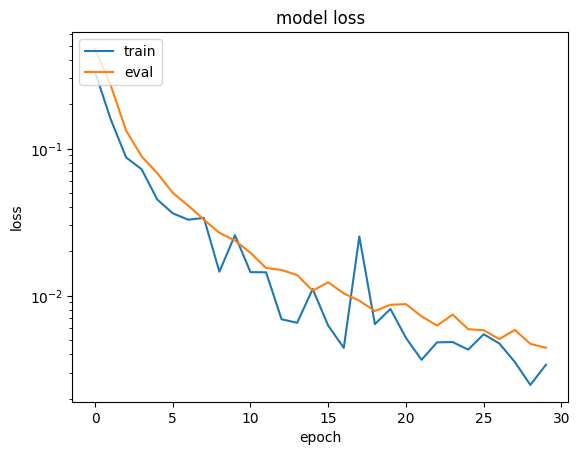

In [5]:
loss_ges = np.append(loss_ges, history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(val_loss_ges)

plt.semilogy(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Step 2: Brigthness and Pixel Shift scattering
Here a higher number of epochs is used to reach the minimum loss function

In [6]:
Batch_Size = 8
Epoch_Anz = 250
Shift_Range = 3
Brightness_Range = 0.3

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], height_shift_range=[-Shift_Range,Shift_Range],brightness_range=[1-Brightness_Range,1+Brightness_Range])

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit(train_iterator, epochs = Epoch_Anz)


Epoch 1/250
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6770 - loss: 0.3889 - val_accuracy: 0.8913 - val_loss: 0.2179
Epoch 2/250
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8337 - loss: 0.1774 - val_accuracy: 0.8696 - val_loss: 0.1087
Epoch 3/250
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8961 - loss: 0.0961 - val_accuracy: 0.9565 - val_loss: 0.0618
Epoch 4/250
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9146 - loss: 0.0767 - val_accuracy: 0.9783 - val_loss: 0.0621
Epoch 5/250
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9258 - loss: 0.0580 - val_accuracy: 0.9348 - val_loss: 0.0580
Epoch 6/250
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9344 - loss: 0.0543 - val_accuracy: 0.9130 - val_loss: 0.0423
Epoch 7/250
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9446 - loss: 0.0407 - val_accuracy: 0.9565 - val_loss: 0.0451
Epoch 8/250
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9443 - loss: 0.0298 - val_accu

### Overall Learing results (Step 1 & Step 2)

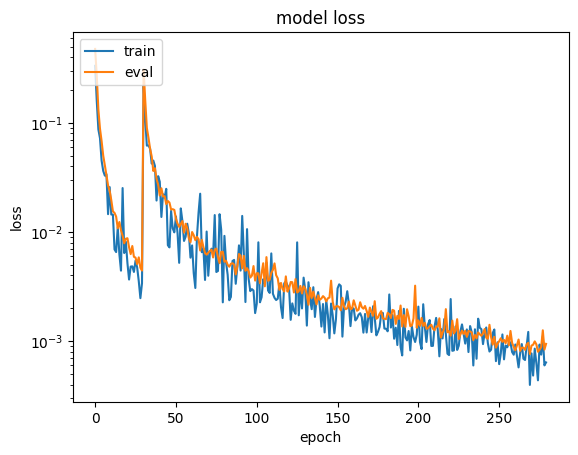

In [7]:
loss_ges = np.append(loss_ges, history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(val_loss_ges)


plt.semilogy(loss_ges)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

Epoch 1/250
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9954 - loss: 7.1440e-04 - val_accuracy: 1.0000 - val_loss: 7.4347e-04
Epoch 2/250
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9931 - loss: 7.7147e-04 - val_accuracy: 1.0000 - val_loss: 5.8319e-04
Epoch 3/250
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9899 - loss: 8.5098e-04 - val_accuracy: 1.0000 - val_loss: 0.0021
Epoch 4/250
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9943 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 9.0610e-04
Epoch 5/250
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9938 - loss: 8.2505e-04 - val_accuracy: 1.0000 - val_loss: 5.5367e-04
Epoch 6/250
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9967 - loss: 7.5645e-04 - val_accuracy: 1.0000 - val_loss: 6.0427e-04
Epoch 7/250
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9890 - loss: 9.0412e-04 - val_accuracy: 1.0000 - val_loss: 9.9981e-04
Epoch 8/250
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/s

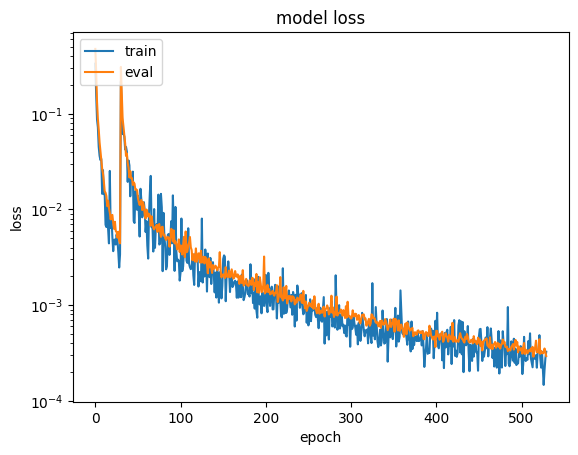

In [8]:
Epoch_Anz = 250
if (Training_Percentage > 0):
    history = model.fit(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    history = model.fit(train_iterator, epochs = Epoch_Anz)
loss_ges = np.append(loss_ges, history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(val_loss_ges)


plt.semilogy(loss_ges)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

Epoch 1/250
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9942 - loss: 3.7415e-04 - val_accuracy: 1.0000 - val_loss: 2.1705e-04
Epoch 2/250
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9982 - loss: 4.1563e-04 - val_accuracy: 1.0000 - val_loss: 2.6990e-04
Epoch 3/250
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9984 - loss: 3.0858e-04 - val_accuracy: 1.0000 - val_loss: 3.6865e-04
Epoch 4/250
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9936 - loss: 3.1576e-04 - val_accuracy: 1.0000 - val_loss: 4.8268e-04
Epoch 5/250
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9969 - loss: 3.7085e-04 - val_accuracy: 1.0000 - val_loss: 2.4456e-04
Epoch 6/250
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9990 - loss: 2.9799e-04 - val_accuracy: 1.0000 - val_loss: 3.5934e-04
Epoch 7/250
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 3.0381e-04 - val_accuracy: 1.0000 - val_loss: 2.1203e-04
Epoch 8/250
114/114 ━━━━━━━━━━━━━━━━━━━━ 

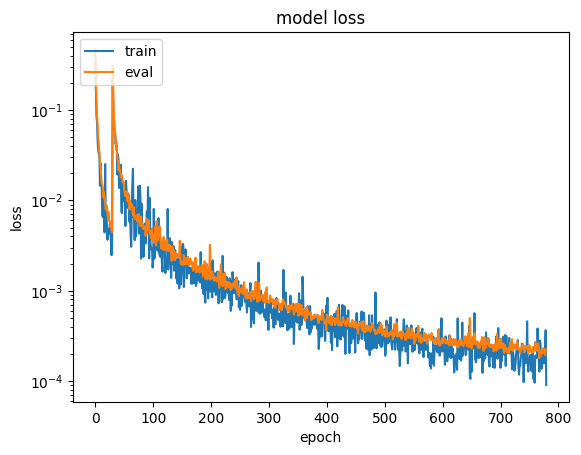

In [9]:
Epoch_Anz = 250
if (Training_Percentage > 0):
    history = model.fit(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    history = model.fit(train_iterator, epochs = Epoch_Anz)
loss_ges = np.append(loss_ges, history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(val_loss_ges)


plt.semilogy(loss_ges)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

Epoch 1/250
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9993 - loss: 1.9633e-04 - val_accuracy: 1.0000 - val_loss: 2.0672e-04
Epoch 2/250
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9986 - loss: 2.3008e-04 - val_accuracy: 1.0000 - val_loss: 1.7168e-04
Epoch 3/250
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9965 - loss: 2.0909e-04 - val_accuracy: 1.0000 - val_loss: 1.9476e-04
Epoch 4/250
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 2.0620e-04 - val_accuracy: 1.0000 - val_loss: 1.9471e-04
Epoch 5/250
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9988 - loss: 2.2186e-04 - val_accuracy: 1.0000 - val_loss: 4.2508e-04
Epoch 6/250
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9999 - loss: 2.1456e-04 - val_accuracy: 1.0000 - val_loss: 1.6071e-04
Epoch 7/250
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.9875e-04 - val_accuracy: 1.0000 - val_loss: 1.8182e-04
Epoch 8/250
114/114 ━━━━━━━━━━━━━━━━━━━━ 

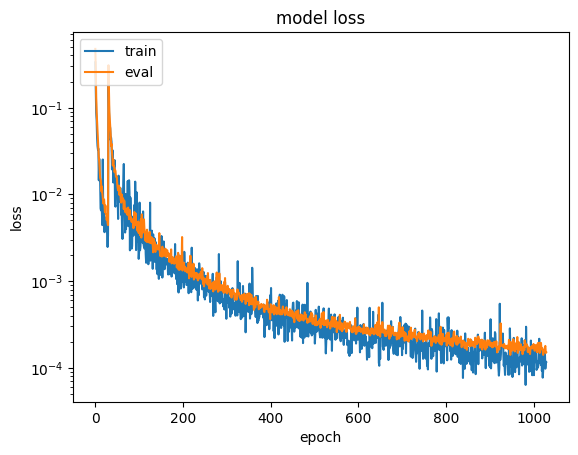

In [10]:
Epoch_Anz = 250
if (Training_Percentage > 0):
    history = model.fit(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    history = model.fit(train_iterator, epochs = Epoch_Anz)
loss_ges = np.append(loss_ges, history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(val_loss_ges)


plt.semilogy(loss_ges)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

Epoch 1/250
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9992 - loss: 1.4823e-04 - val_accuracy: 1.0000 - val_loss: 1.2271e-04
Epoch 2/250
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9990 - loss: 1.5277e-04 - val_accuracy: 1.0000 - val_loss: 2.2144e-04
Epoch 3/250
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9998 - loss: 1.4849e-04 - val_accuracy: 1.0000 - val_loss: 1.1799e-04
Epoch 4/250
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9984 - loss: 1.6031e-04 - val_accuracy: 1.0000 - val_loss: 1.0865e-04
Epoch 5/250
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.4951e-04 - val_accuracy: 1.0000 - val_loss: 1.5273e-04
Epoch 6/250
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 1.4388e-04 - val_accuracy: 1.0000 - val_loss: 9.9258e-05
Epoch 7/250
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9999 - loss: 1.4657e-04 - val_accuracy: 1.0000 - val_loss: 1.0262e-04
Epoch 8/250
114/114 ━━━━━━━━━━━━━━━━━━━━ 

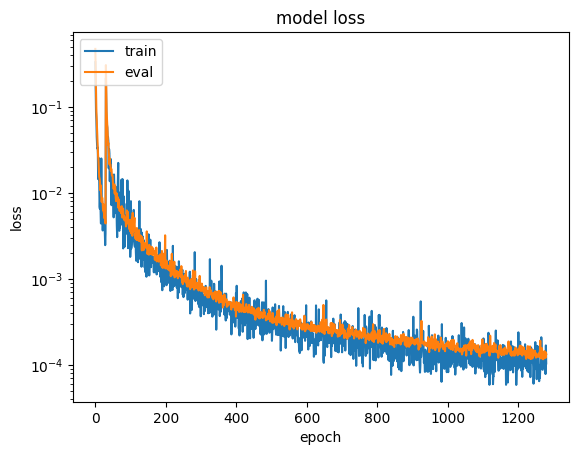

In [11]:
Epoch_Anz = 250
if (Training_Percentage > 0):
    history = model.fit(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    history = model.fit(train_iterator, epochs = Epoch_Anz)
loss_ges = np.append(loss_ges, history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(val_loss_ges)


plt.semilogy(loss_ges)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

In [ ]:
Epoch_Anz = 250
if (Training_Percentage > 0):
    history = model.fit(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    history = model.fit(train_iterator, epochs = Epoch_Anz)
loss_ges = np.append(loss_ges, history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(val_loss_ges)


plt.semilogy(loss_ges)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

Epoch 1/250
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9990 - loss: 1.1573e-04 - val_accuracy: 1.0000 - val_loss: 6.6536e-05
Epoch 2/250
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9998 - loss: 1.3536e-04 - val_accuracy: 1.0000 - val_loss: 1.2530e-04
Epoch 3/250
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 1.2384e-04 - val_accuracy: 1.0000 - val_loss: 9.9568e-05
Epoch 4/250
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 1.2297e-04 - val_accuracy: 1.0000 - val_loss: 1.0670e-04
Epoch 5/250
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9962 - loss: 1.1588e-04 - val_accuracy: 1.0000 - val_loss: 8.2078e-05
Epoch 6/250
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 1.2588e-04 - val_accuracy: 1.0000 - val_loss: 1.3318e-04
Epoch 7/250
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.4160e-04 - val_accuracy: 1.0000 - val_loss: 5.6193e-05
Epoch 8/250
114/114 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
Epoch_Anz = 500
if (Training_Percentage > 0):
    history = model.fit(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    history = model.fit(train_iterator, epochs = Epoch_Anz)
loss_ges = np.append(loss_ges, history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(val_loss_ges)


plt.semilogy(loss_ges)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 1.0000 - loss: 9.8400e-05 - val_accuracy: 1.0000 - val_loss: 9.2767e-05
Epoch 318/500
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 1.0000 - loss: 8.6532e-05 - val_accuracy: 1.0000 - val_loss: 5.7257e-05
Epoch 319/500
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9995 - loss: 1.1521e-04 - val_accuracy: 1.0000 - val_loss: 9.4328e-05
Epoch 320/500
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 8.4244e-05 - val_accuracy: 1.0000 - val_loss: 6.0206e-05
Epoch 321/500
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9983 - loss: 1.0273e-04 - val_accuracy: 1.0000 - val_loss: 9.8403e-05
Epoch 322/500
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9982 - loss: 1.0356e-04 - val_accuracy: 1.0000 - val_loss: 7.3675e-05
Epoch 323/500
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 1.0740e-04 - val_accuracy: 1.0000 - val_loss: 8.1531e-05
Epoch 324/500
114/114 ━━━━━━━━━━━━━━━━━

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* The evaluation takes the periodic character of the results into account (dev1 ... dev2).
* Images, that have a bigger deviation as the parameter "deviation_max_list" are printed in a list to check the picture and labeling itself

In [14]:
Input_dir='data_resize_all'
#Input_dir='test_result'
files = glob.glob(Input_dir + '/*.*')
res = []
stat_Anz = []
stat_Abweichung = []
i = 0
deviation_max_list = 0.15

for i in range(100):
    stat_Anz.append(0)
    stat_Abweichung.append(0)

for aktfile in sorted(files):
    base = os.path.basename(aktfile)
    target = (float(base[0:3])) / 10
    
    target_sin = math.sin(target * math.pi * 2)
    target_cos = math.cos(target * math.pi * 2)

    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    img = np.reshape(test_image,[1,32,32,3])
    classes = model.predict(img, verbose=0)
    
    out_sin = classes[0][0]  
    out_cos = classes[0][1]
    out_target = (np.arctan2(out_sin, out_cos)/(2*math.pi)) % 1

    dev_sin = target_sin - out_sin
    dev_cos = target_cos - out_cos
    dev_target = target - out_target
    
    if abs(dev_target + 1) < abs(dev_target):
        out_target = out_target - 1
        dev_target = target - out_target
    else:
        if abs(dev_target - 1) < abs(dev_target):
            out_target = out_target + 1
            dev_target = target - out_target
            
    target_int = int ((float(base[0:3])) * 10)
    stat_Abweichung[target_int] = stat_Abweichung[target_int] + dev_target  
    stat_Anz[target_int] = stat_Anz[target_int] + 1
               
    res.append(np.array([target, out_target, dev_target, out_sin, out_cos, i]))
    if abs(dev_target) > deviation_max_list:
        print(aktfile + " " + str(target) + " " + str(out_target) +  " " + str(dev_target))

    
for i in range(100):
    stat_Abweichung[i] = stat_Abweichung[i] / stat_Anz[i]

res = np.asarray(res)
res_step_1 = res

data_resize_all\2.9_2ad3dd7d058798612aef75f5f958534d.jpg 0.29 0.13457039 0.1554296
data_resize_all\3.0_ec2227062fae8051411745527befc6c4.jpg 0.3 0.1474451 0.15255491
data_resize_all\3.1_c397aa89e178c4b4f6c6bc480016a441.jpg 0.31 0.07045889 0.23954111
data_resize_all\3.2_4904930dbce0bc29d32254e676022863.jpg 0.32 0.07778881 0.2422112
data_resize_all\3.8_157e6c33abee9facbff527eb49e41377.jpg 0.38 0.04325875 0.33674124
data_resize_all\5.3_84c20b8e22b48cfdb97a445df75a4a50.jpg 0.53 0.68398523 -0.15398526


## Results

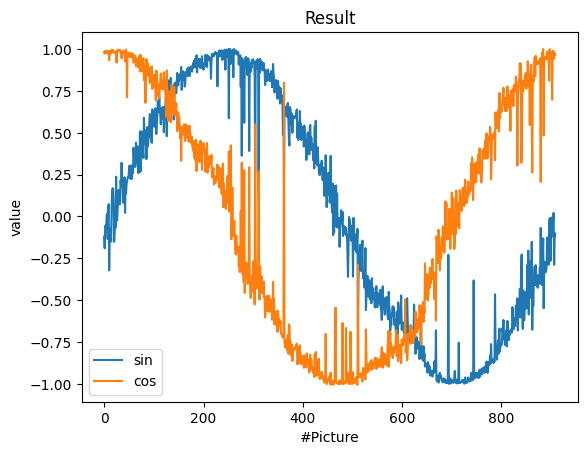

In [15]:
plt.plot(res[:,3])
plt.plot(res[:,4])
plt.title('Result')
plt.ylabel('value')
plt.xlabel('#Picture')
plt.legend(['sin', 'cos'], loc='lower left')
plt.show()

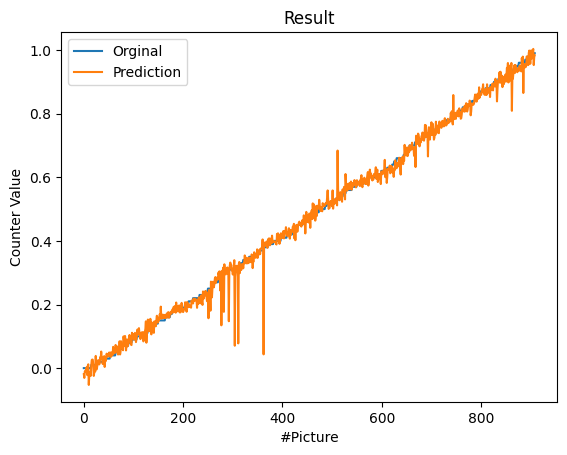

In [16]:
plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Counter Value')
plt.xlabel('#Picture')
plt.legend(['Orginal', 'Prediction'], loc='upper left')
plt.show()

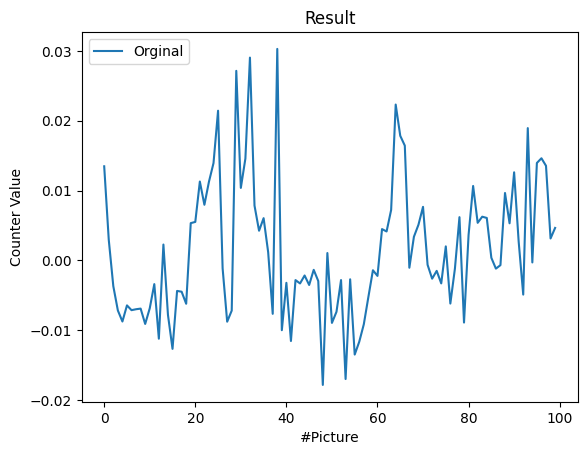

In [17]:
plt.plot(stat_Abweichung)
plt.title('Result')
plt.ylabel('Counter Value')
plt.xlabel('#Picture')
plt.legend(['Orginal', 'Prediction'], loc='upper left')
plt.show()

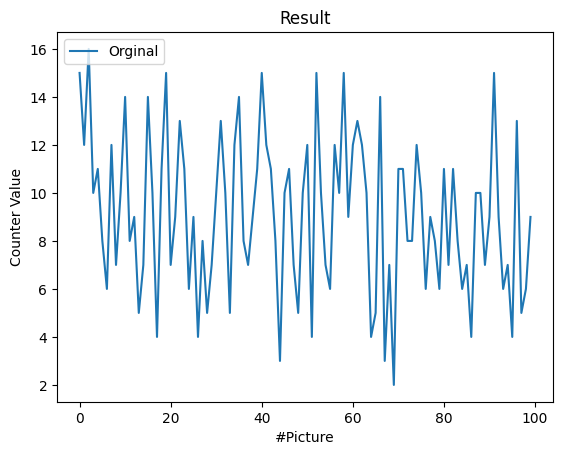

In [18]:
plt.plot(stat_Anz)
plt.title('Result')
plt.ylabel('Counter Value')
plt.xlabel('#Picture')
plt.legend(['Orginal', 'Prediction'], loc='upper left')
plt.show()

### Deviation from Expected Value

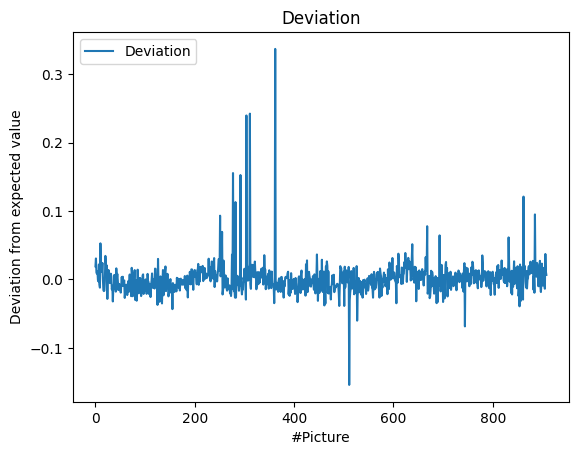

[ 0.0013  0.0248 -0.154   0.3367]


In [19]:
plt.plot(res[:,2])
plt.title('Deviation')
plt.ylabel('Deviation from expected value')
plt.xlabel('#Picture')
plt.legend(['Deviation'], loc='upper left')
#plt.ylim(-0.3, 0.3)
plt.show()

statistic = np.array([np.mean(res[:,2]), np.std(res[:,2]), np.min(res[:,2]), np.max(res[:,2])])
print(statistic)

### Save the model

* Save the model to the file with the "h5" file format

In [20]:
model.export("test", "tf_saved_model")  # replace tf.saved_model.save with this line

INFO:tensorflow:Assets written to: test\assets


INFO:tensorflow:Assets written to: test\assets


Saved artifact at 'test'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  1805701978576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1805701981840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1805701979152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1805701982608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1805390027792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1805390028560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1805701978768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1805390029136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1805390028752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1805390030096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1805390031056: TensorSpec(shape=(), dtype=tf.res

In [21]:
FileName = TFlite_MainType + "_" + TFlite_Version + "_" + TFlite_Size

converter = tf.lite.TFLiteConverter.from_saved_model("test")
tflite_model = converter.convert()
open(FileName + ".tflite", "wb").write(tflite_model)

365764

In [22]:
from pathlib import Path
import tensorflow as tf

FileName = FileName = TFlite_MainType + "_" + TFlite_Version + "_" + TFlite_Size + "_q.tflite"

def representative_dataset():
    for n in range(x_data[0].size):
      data = np.expand_dims(x_data[5], axis=0)
      yield [data.astype(np.float32)]

converter = tf.lite.TFLiteConverter.from_saved_model("test")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter._experimental_disable_per_channel_quantization_for_dense_layers = True
tflite_quant_model = converter.convert()

open(FileName, "wb").write(tflite_quant_model)
print(FileName)
Path(FileName).stat().st_size

ana-cont_1501_s0_q.tflite


100328